# Out-of-sample forecasting experiments

I conduct out-of-sample forecasting experiments to understand what kind of text data (topics, sentiment, or uncertainty) helps improve forecasts of three quarterly variables (GDP, Investment, and Consumption) more.

In this notebook, I evaluate the performance of dynamic factor models (DFM) using hard data, survey information, and 10 pre-selected sign-adjusted topics (BCC) (out of 200 topics estimated on articles published before 2010 using all sources). I forecast GDP growth and integrate text data into economic forecasting.

## Experiment Details

- **Data Sources:** Hard data, surveys, 10 pre-selected sign-adjusted topics, BCC (<=2009, 200 topics, all sources).
- **Forecast Target:** GDP growth.
- **Model:** Dynamic Factor Models (DFM).
- **Parameters Explored:**
  - **Number of Global Factors:** 1 to 3
  - **Factor Order:** 1 to 3 (for each number of factors)

In [1]:
import os
import time
import datetime
import pandas as pd
import DFM_function

# Define inputs common to all models
q_var = 'GDP'                      # quarterly variable being forecasted
additional_factors = None          # or "all" or e.g. ['Labor market']
start = '1991-04'
text_type = "topics_BCC"
estimation_period = "2009"
num_topics = "200"
source = "all"
selected = "_selected"
with_text = True

# Generate list of forecast_month strings for quarters from 2008Q1 to 2018Q4
# forecast_month is set to the month corresponding to quarter-end:
# Q1: 'YYYY-03', Q2: 'YYYY-06', Q3: 'YYYY-09', Q4: 'YYYY-12'
forecast_months = []
for year in range(2008, 2019):
    forecast_months.extend([f"{year}-03", f"{year}-06", f"{year}-09", f"{year}-12"])
    
# Define the vintage column names 
vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]

# Create directories to save forecasts and MSE results
os.makedirs(f"../forecasts/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_global_factors_{q_var}", exist_ok=True)
os.makedirs(f"../MSE/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_global_factors_{q_var}", exist_ok=True)

# Load the actual growth data
actual_growth_file = f"../{q_var}_growth_actual.csv"
actual_growth = pd.read_csv(actual_growth_file)

# Record overall start time
overall_start = time.time()

# Loop over the number of factors and factor order values from 1 to 3
for num_factors in range(1, 4):  # Varying number of Global factors: 1, 2, 3
    for order in range(1, 4):    # Varying factor order: 1, 2, 3
        
        # Define model-specific parameters
        factor_multiplicities = {'Global': num_factors}
        factor_orders = {'Global': order}

        # Prepare lists to store each quarter's forecasts and row labels
        forecasts_all_quarters = []
        row_labels = []
        
        # Start timing for this model
        start_time = time.time()

        # Loop over each forecast month, get the forecasts, and store the results
        for fm in forecast_months:
            # Use the forecast_month string as the row label
            row_labels.append(fm)

            # Run the forecast function for this quarter
            forecasts_dict = DFM_function.get_forecasts(
                forecast_month = fm,
                q_var = q_var,
                additional_factors = additional_factors,
                factor_multiplicities = factor_multiplicities,
                factor_orders = factor_orders,
                start = start,
                text_type = text_type,
                estimation_period = estimation_period,
                num_topics = num_topics,
                source = source,
                selected = selected,
                with_text = with_text
            )

            # Obtain the correct ordering of vintages
            vintages_order = DFM_function.vintage_dates(fm)
            # Extract the forecast value for each vintage in that order
            quarter_forecasts = [forecasts_dict[vint] for vint in vintages_order]
            forecasts_all_quarters.append(quarter_forecasts)

        # Create a DataFrame with rows labeled by the forecast_month strings and columns as vintage names
        results = pd.DataFrame(forecasts_all_quarters, index=row_labels, columns=vintage_col_names)
        
        # Stop timing for this model and print elapsed time
        elapsed = time.time() - start_time
        elapsed_time = datetime.timedelta(seconds=elapsed)
        print(f"Model with Global factors = {num_factors} and order = {order} estimated in {elapsed_time}.")

        # Construct the output file name
        factors_str = "_".join([
            f"{factor.replace(' ', '_')}_{factor_multiplicities[factor]}_{factor_orders[factor]}"
            for factor in factor_multiplicities])
        file_name = f"forecasts_{q_var}_{factors_str}.csv"

        # Save the CSV file in a subfolder 
        output_path = os.path.join(f"../forecasts/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_global_factors_{q_var}", file_name)
        results.to_csv(output_path, index=True)
        
        # ----- MSE Calculation -----
        # Load forecasts
        forecasts = pd.read_csv(output_path, index_col=0)
        # Make sure the index is a column named "date"
        forecasts.index.name = "date"
        forecasts.reset_index(inplace=True)

        # Merge dfs by date 
        merged = pd.merge(forecasts, actual_growth, on="date", how="inner")

        # Calculate the Mean Squared Error (MSE) for each vintage column
        mse_dict = {}
        for col in vintage_col_names:
            mse = ((merged[col] - merged["growth"]) ** 2).mean()
            mse_dict[col] = mse

        # Create a df with one row (the MSE values for each forecasting horizon)
        mse_df = pd.DataFrame(mse_dict, index=[0])

        # Save MSE results to CSV
        mse_file_name = f"MSE_{q_var}_{factors_str}.csv"
        mse_output_path = os.path.join(f"../MSE/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_global_factors_{q_var}", mse_file_name)
        mse_df.to_csv(mse_output_path, index=False)
        
# Stop overall timing and print overall elapsed time
overall_elapsed = time.time() - overall_start
overall_elapsed_time = datetime.timedelta(seconds=overall_elapsed)
print(f"Overall time taken for running all models: {overall_elapsed_time}.")

EM start iterations, llf=-11835
EM iteration 50, llf=-11673, convergence criterion=1.4425e-06
EM converged at iteration 61, llf=-11673, convergence criterion=9.6674e-07 < tolerance=1e-06
EM start iterations, llf=-11847
EM iteration 50, llf=-11684, convergence criterion=1.444e-06
EM converged at iteration 61, llf=-11684, convergence criterion=9.6781e-07 < tolerance=1e-06
EM start iterations, llf=-11904
EM iteration 50, llf=-11739, convergence criterion=1.4468e-06
EM converged at iteration 61, llf=-11739, convergence criterion=9.6963e-07 < tolerance=1e-06
EM start iterations, llf=-11912
EM iteration 50, llf=-11747, convergence criterion=1.4402e-06
EM converged at iteration 60, llf=-11747, convergence criterion=9.9885e-07 < tolerance=1e-06
EM start iterations, llf=-11978
EM iteration 50, llf=-11812, convergence criterion=1.4505e-06
EM converged at iteration 61, llf=-11811, convergence criterion=9.7251e-07 < tolerance=1e-06
EM start iterations, llf=-11986
EM iteration 50, llf=-11821, conve

EM converged at iteration 35, llf=-12923, convergence criterion=9.5174e-07 < tolerance=1e-06
EM start iterations, llf=-13113
EM converged at iteration 34, llf=-12980, convergence criterion=9.9299e-07 < tolerance=1e-06
EM start iterations, llf=-13124
EM converged at iteration 35, llf=-12991, convergence criterion=9.6382e-07 < tolerance=1e-06
EM start iterations, llf=-13174
EM converged at iteration 35, llf=-13042, convergence criterion=9.6077e-07 < tolerance=1e-06
EM start iterations, llf=-13223
EM converged at iteration 34, llf=-13089, convergence criterion=9.8783e-07 < tolerance=1e-06
EM start iterations, llf=-13277
EM converged at iteration 34, llf=-13143, convergence criterion=9.8317e-07 < tolerance=1e-06
EM start iterations, llf=-13277
EM converged at iteration 34, llf=-13143, convergence criterion=9.8317e-07 < tolerance=1e-06
EM start iterations, llf=-13286
EM converged at iteration 34, llf=-13152, convergence criterion=9.8644e-07 < tolerance=1e-06
EM start iterations, llf=-13331


EM start iterations, llf=-14777
EM converged at iteration 34, llf=-14628, convergence criterion=9.8829e-07 < tolerance=1e-06
EM start iterations, llf=-14789
EM converged at iteration 34, llf=-14640, convergence criterion=9.8826e-07 < tolerance=1e-06
EM start iterations, llf=-14837
EM converged at iteration 34, llf=-14686, convergence criterion=9.8461e-07 < tolerance=1e-06
EM start iterations, llf=-14837
EM converged at iteration 34, llf=-14686, convergence criterion=9.8461e-07 < tolerance=1e-06
EM start iterations, llf=-14844
EM converged at iteration 34, llf=-14694, convergence criterion=9.9015e-07 < tolerance=1e-06
EM start iterations, llf=-14896
EM converged at iteration 34, llf=-14746, convergence criterion=9.8916e-07 < tolerance=1e-06
EM start iterations, llf=-14903
EM converged at iteration 35, llf=-14753, convergence criterion=9.46e-07 < tolerance=1e-06
EM start iterations, llf=-14958
EM converged at iteration 34, llf=-14807, convergence criterion=9.9835e-07 < tolerance=1e-06
EM

EM start iterations, llf=-16524
EM converged at iteration 27, llf=-16367, convergence criterion=9.2882e-07 < tolerance=1e-06
EM start iterations, llf=-16528
EM converged at iteration 26, llf=-16370, convergence criterion=9.946e-07 < tolerance=1e-06
EM start iterations, llf=-16579
EM converged at iteration 26, llf=-16420, convergence criterion=9.9331e-07 < tolerance=1e-06
EM start iterations, llf=-16587
EM converged at iteration 27, llf=-16427, convergence criterion=9.2984e-07 < tolerance=1e-06
EM start iterations, llf=-16642
EM converged at iteration 27, llf=-16481, convergence criterion=9.2739e-07 < tolerance=1e-06
EM start iterations, llf=-16648
EM converged at iteration 27, llf=-16488, convergence criterion=9.2824e-07 < tolerance=1e-06
EM start iterations, llf=-16695
EM converged at iteration 27, llf=-16535, convergence criterion=9.2675e-07 < tolerance=1e-06
EM start iterations, llf=-16695
EM converged at iteration 27, llf=-16535, convergence criterion=9.2675e-07 < tolerance=1e-06
E

EM start iterations, llf=-18261
EM converged at iteration 28, llf=-18092, convergence criterion=9.6716e-07 < tolerance=1e-06
EM start iterations, llf=-18305
EM converged at iteration 28, llf=-18136, convergence criterion=9.6829e-07 < tolerance=1e-06
EM start iterations, llf=-18315
EM converged at iteration 28, llf=-18146, convergence criterion=9.6541e-07 < tolerance=1e-06
EM start iterations, llf=-18173
EM converged at iteration 28, llf=-18009, convergence criterion=9.8755e-07 < tolerance=1e-06
EM start iterations, llf=-18173
EM converged at iteration 28, llf=-18009, convergence criterion=9.8755e-07 < tolerance=1e-06
EM start iterations, llf=-18178
EM converged at iteration 28, llf=-18013, convergence criterion=9.8183e-07 < tolerance=1e-06
EM start iterations, llf=-18230
EM converged at iteration 28, llf=-18064, convergence criterion=9.7691e-07 < tolerance=1e-06
EM start iterations, llf=-18242
EM converged at iteration 28, llf=-18078, convergence criterion=9.8294e-07 < tolerance=1e-06


EM iteration 50, llf=-11883, convergence criterion=1.6907e-06
EM converged at iteration 66, llf=-11883, convergence criterion=9.8146e-07 < tolerance=1e-06
EM start iterations, llf=-12105
EM iteration 50, llf=-11935, convergence criterion=1.7145e-06
EM converged at iteration 66, llf=-11935, convergence criterion=9.9346e-07 < tolerance=1e-06
EM start iterations, llf=-12113
EM iteration 50, llf=-11943, convergence criterion=1.5692e-06
EM converged at iteration 63, llf=-11943, convergence criterion=9.9078e-07 < tolerance=1e-06
EM start iterations, llf=-12155
EM iteration 50, llf=-11981, convergence criterion=1.579e-06
EM converged at iteration 63, llf=-11981, convergence criterion=9.9392e-07 < tolerance=1e-06
EM start iterations, llf=-12165
EM iteration 50, llf=-11991, convergence criterion=1.5808e-06
EM converged at iteration 63, llf=-11991, convergence criterion=9.9531e-07 < tolerance=1e-06
EM start iterations, llf=-12213
EM iteration 50, llf=-12035, convergence criterion=1.6318e-06
EM c

EM start iterations, llf=-13451
EM converged at iteration 35, llf=-13312, convergence criterion=9.7483e-07 < tolerance=1e-06
EM start iterations, llf=-13460
EM converged at iteration 35, llf=-13321, convergence criterion=9.8425e-07 < tolerance=1e-06
EM start iterations, llf=-13507
EM converged at iteration 34, llf=-13367, convergence criterion=9.9643e-07 < tolerance=1e-06
EM start iterations, llf=-13513
EM converged at iteration 34, llf=-13373, convergence criterion=9.9056e-07 < tolerance=1e-06
EM start iterations, llf=-13572
EM converged at iteration 34, llf=-13430, convergence criterion=9.7423e-07 < tolerance=1e-06
EM start iterations, llf=-13584
EM converged at iteration 34, llf=-13443, convergence criterion=9.8713e-07 < tolerance=1e-06
EM start iterations, llf=-13634
EM converged at iteration 34, llf=-13493, convergence criterion=9.8487e-07 < tolerance=1e-06
EM start iterations, llf=-13634
EM converged at iteration 34, llf=-13493, convergence criterion=9.8487e-07 < tolerance=1e-06


EM start iterations, llf=-15099
EM converged at iteration 36, llf=-14948, convergence criterion=9.833e-07 < tolerance=1e-06
EM start iterations, llf=-15146
EM converged at iteration 36, llf=-14995, convergence criterion=9.8141e-07 < tolerance=1e-06
EM start iterations, llf=-15154
EM converged at iteration 36, llf=-15003, convergence criterion=9.8163e-07 < tolerance=1e-06
EM start iterations, llf=-15201
EM converged at iteration 36, llf=-15050, convergence criterion=9.8089e-07 < tolerance=1e-06
EM start iterations, llf=-15201
EM converged at iteration 36, llf=-15050, convergence criterion=9.8089e-07 < tolerance=1e-06
EM start iterations, llf=-15213
EM converged at iteration 36, llf=-15062, convergence criterion=9.7858e-07 < tolerance=1e-06
EM start iterations, llf=-15258
EM converged at iteration 36, llf=-15107, convergence criterion=9.7557e-07 < tolerance=1e-06
EM start iterations, llf=-15269
EM converged at iteration 35, llf=-15117, convergence criterion=9.8691e-07 < tolerance=1e-06
E

EM start iterations, llf=-16890
EM converged at iteration 28, llf=-16729, convergence criterion=9.9321e-07 < tolerance=1e-06
EM start iterations, llf=-16890
EM converged at iteration 28, llf=-16729, convergence criterion=9.9321e-07 < tolerance=1e-06
EM start iterations, llf=-16898
EM converged at iteration 28, llf=-16735, convergence criterion=9.8418e-07 < tolerance=1e-06
EM start iterations, llf=-16950
EM converged at iteration 28, llf=-16787, convergence criterion=9.7495e-07 < tolerance=1e-06
EM start iterations, llf=-16960
EM converged at iteration 28, llf=-16797, convergence criterion=9.7842e-07 < tolerance=1e-06
EM start iterations, llf=-17010
EM converged at iteration 28, llf=-16847, convergence criterion=9.7975e-07 < tolerance=1e-06
EM start iterations, llf=-17022
EM converged at iteration 28, llf=-16859, convergence criterion=9.8127e-07 < tolerance=1e-06
EM start iterations, llf=-17077
EM converged at iteration 28, llf=-16913, convergence criterion=9.7363e-07 < tolerance=1e-06


EM start iterations, llf=-18420
EM converged at iteration 29, llf=-18253, convergence criterion=9.972e-07 < tolerance=1e-06
EM start iterations, llf=-18428
EM converged at iteration 30, llf=-18262, convergence criterion=9.6757e-07 < tolerance=1e-06
EM start iterations, llf=-18484
EM converged at iteration 30, llf=-18316, convergence criterion=9.6413e-07 < tolerance=1e-06
EM start iterations, llf=-18491
EM converged at iteration 30, llf=-18323, convergence criterion=9.6316e-07 < tolerance=1e-06
EM start iterations, llf=-18547
EM converged at iteration 30, llf=-18378, convergence criterion=9.5872e-07 < tolerance=1e-06
EM start iterations, llf=-18547
EM converged at iteration 30, llf=-18378, convergence criterion=9.5872e-07 < tolerance=1e-06
EM start iterations, llf=-18552
EM converged at iteration 30, llf=-18385, convergence criterion=9.6154e-07 < tolerance=1e-06
EM start iterations, llf=-18608
EM converged at iteration 30, llf=-18440, convergence criterion=9.543e-07 < tolerance=1e-06
EM

EM start iterations, llf=-12276
EM iteration 50, llf=-12093, convergence criterion=1.1335e-06
EM converged at iteration 53, llf=-12093, convergence criterion=9.958e-07 < tolerance=1e-06
EM start iterations, llf=-12321
EM iteration 50, llf=-12130, convergence criterion=1.1706e-06
EM converged at iteration 54, llf=-12130, convergence criterion=9.8671e-07 < tolerance=1e-06
EM start iterations, llf=-12329
EM iteration 50, llf=-12137, convergence criterion=1.1694e-06
EM converged at iteration 54, llf=-12137, convergence criterion=9.856e-07 < tolerance=1e-06
EM start iterations, llf=-12396
EM iteration 50, llf=-12210, convergence criterion=1.1586e-06
EM converged at iteration 54, llf=-12210, convergence criterion=9.7722e-07 < tolerance=1e-06
EM start iterations, llf=-12396
EM iteration 50, llf=-12210, convergence criterion=1.1586e-06
EM converged at iteration 54, llf=-12210, convergence criterion=9.7722e-07 < tolerance=1e-06
EM start iterations, llf=-12396
EM iteration 50, llf=-12204, conver

EM start iterations, llf=-13457
EM converged at iteration 43, llf=-13321, convergence criterion=9.9424e-07 < tolerance=1e-06
EM start iterations, llf=-13502
EM iteration 50, llf=-13366, convergence criterion=1.0867e-06
EM converged at iteration 53, llf=-13366, convergence criterion=9.8802e-07 < tolerance=1e-06
EM start iterations, llf=-13508
EM iteration 50, llf=-13371, convergence criterion=1.1053e-06
EM converged at iteration 54, llf=-13371, convergence criterion=9.7241e-07 < tolerance=1e-06
EM start iterations, llf=-13567
EM iteration 50, llf=-13429, convergence criterion=1.0755e-06
EM converged at iteration 54, llf=-13429, convergence criterion=9.8105e-07 < tolerance=1e-06
EM start iterations, llf=-13580
EM iteration 50, llf=-13442, convergence criterion=1.0615e-06
EM converged at iteration 53, llf=-13442, convergence criterion=9.9713e-07 < tolerance=1e-06
EM start iterations, llf=-13630
EM iteration 50, llf=-13492, convergence criterion=1.064e-06
EM converged at iteration 54, llf=

EM converged at iteration 37, llf=-14693, convergence criterion=9.6492e-07 < tolerance=1e-06
EM start iterations, llf=-14892
EM converged at iteration 36, llf=-14745, convergence criterion=9.7808e-07 < tolerance=1e-06
EM start iterations, llf=-14900
EM converged at iteration 36, llf=-14753, convergence criterion=9.9245e-07 < tolerance=1e-06
EM start iterations, llf=-14954
EM converged at iteration 36, llf=-14807, convergence criterion=9.9743e-07 < tolerance=1e-06
EM start iterations, llf=-14963
EM converged at iteration 37, llf=-14815, convergence criterion=9.532e-07 < tolerance=1e-06
EM start iterations, llf=-15021
EM converged at iteration 38, llf=-14873, convergence criterion=9.7218e-07 < tolerance=1e-06
EM start iterations, llf=-15021
EM converged at iteration 38, llf=-14873, convergence criterion=9.7218e-07 < tolerance=1e-06
EM start iterations, llf=-15031
EM converged at iteration 38, llf=-14883, convergence criterion=9.6885e-07 < tolerance=1e-06
EM start iterations, llf=-15084
E

EM start iterations, llf=-16574
EM converged at iteration 43, llf=-16419, convergence criterion=9.8215e-07 < tolerance=1e-06
EM start iterations, llf=-16582
EM converged at iteration 42, llf=-16426, convergence criterion=9.966e-07 < tolerance=1e-06
EM start iterations, llf=-16637
EM converged at iteration 42, llf=-16480, convergence criterion=9.8358e-07 < tolerance=1e-06
EM start iterations, llf=-16643
EM converged at iteration 42, llf=-16486, convergence criterion=9.9286e-07 < tolerance=1e-06
EM start iterations, llf=-16690
EM converged at iteration 43, llf=-16533, convergence criterion=9.7804e-07 < tolerance=1e-06
EM start iterations, llf=-16690
EM converged at iteration 43, llf=-16533, convergence criterion=9.7804e-07 < tolerance=1e-06
EM start iterations, llf=-16703
EM converged at iteration 42, llf=-16547, convergence criterion=9.9468e-07 < tolerance=1e-06
EM start iterations, llf=-16764
EM converged at iteration 44, llf=-16607, convergence criterion=9.9088e-07 < tolerance=1e-06
E

EM start iterations, llf=-18309
EM converged at iteration 45, llf=-18144, convergence criterion=9.831e-07 < tolerance=1e-06
EM start iterations, llf=-18168
EM converged at iteration 45, llf=-18007, convergence criterion=9.8548e-07 < tolerance=1e-06
EM start iterations, llf=-18168
EM converged at iteration 45, llf=-18007, convergence criterion=9.8548e-07 < tolerance=1e-06
EM start iterations, llf=-18173
EM converged at iteration 45, llf=-18011, convergence criterion=9.8817e-07 < tolerance=1e-06
EM start iterations, llf=-18224
EM converged at iteration 45, llf=-18062, convergence criterion=9.8827e-07 < tolerance=1e-06
EM start iterations, llf=-18237
EM converged at iteration 45, llf=-18076, convergence criterion=9.8844e-07 < tolerance=1e-06
EM start iterations, llf=-18295
EM converged at iteration 45, llf=-18133, convergence criterion=9.8791e-07 < tolerance=1e-06
EM start iterations, llf=-18299
EM converged at iteration 45, llf=-18137, convergence criterion=9.8917e-07 < tolerance=1e-06
E

EM converged at iteration 59, llf=-11424, convergence criterion=9.9604e-07 < tolerance=1e-06
EM start iterations, llf=-11570
EM iteration 50, llf=-11435, convergence criterion=1.298e-06
EM converged at iteration 57, llf=-11435, convergence criterion=9.8442e-07 < tolerance=1e-06
EM start iterations, llf=-11613
EM iteration 50, llf=-11479, convergence criterion=1.2567e-06
EM converged at iteration 56, llf=-11479, convergence criterion=9.8989e-07 < tolerance=1e-06
EM start iterations, llf=-11620
EM iteration 50, llf=-11487, convergence criterion=1.2571e-06
EM converged at iteration 56, llf=-11487, convergence criterion=9.9007e-07 < tolerance=1e-06
EM start iterations, llf=-11662
EM iteration 50, llf=-11530, convergence criterion=1.2755e-06
EM converged at iteration 57, llf=-11529, convergence criterion=9.6803e-07 < tolerance=1e-06
EM start iterations, llf=-11662
EM iteration 50, llf=-11530, convergence criterion=1.2755e-06
EM converged at iteration 57, llf=-11529, convergence criterion=9.

EM start iterations, llf=-12795
EM converged at iteration 48, llf=-12637, convergence criterion=9.8916e-07 < tolerance=1e-06
EM start iterations, llf=-12841
EM converged at iteration 48, llf=-12683, convergence criterion=9.7268e-07 < tolerance=1e-06
EM start iterations, llf=-12841
EM converged at iteration 48, llf=-12683, convergence criterion=9.7268e-07 < tolerance=1e-06
EM start iterations, llf=-12849
EM converged at iteration 47, llf=-12691, convergence criterion=9.5888e-07 < tolerance=1e-06
EM start iterations, llf=-12902
EM converged at iteration 48, llf=-12743, convergence criterion=9.7842e-07 < tolerance=1e-06
EM start iterations, llf=-12909
EM converged at iteration 48, llf=-12750, convergence criterion=9.909e-07 < tolerance=1e-06
EM start iterations, llf=-12955
EM converged at iteration 48, llf=-12793, convergence criterion=9.7941e-07 < tolerance=1e-06
EM start iterations, llf=-12964
EM converged at iteration 48, llf=-12802, convergence criterion=9.7889e-07 < tolerance=1e-06
E

EM converged at iteration 47, llf=-14064, convergence criterion=9.902e-07 < tolerance=1e-06
EM start iterations, llf=-14248
EM converged at iteration 47, llf=-14072, convergence criterion=9.9106e-07 < tolerance=1e-06
EM start iterations, llf=-14297
EM converged at iteration 47, llf=-14121, convergence criterion=9.8247e-07 < tolerance=1e-06
EM start iterations, llf=-14306
EM converged at iteration 47, llf=-14130, convergence criterion=9.8377e-07 < tolerance=1e-06
EM start iterations, llf=-14360
EM converged at iteration 47, llf=-14186, convergence criterion=9.6056e-07 < tolerance=1e-06
EM start iterations, llf=-14360
EM converged at iteration 47, llf=-14186, convergence criterion=9.6056e-07 < tolerance=1e-06
EM start iterations, llf=-14369
EM converged at iteration 46, llf=-14195, convergence criterion=9.9946e-07 < tolerance=1e-06
EM start iterations, llf=-14419
EM converged at iteration 46, llf=-14245, convergence criterion=9.8944e-07 < tolerance=1e-06
EM start iterations, llf=-14430
E

EM start iterations, llf=-15918
EM converged at iteration 37, llf=-15735, convergence criterion=9.6308e-07 < tolerance=1e-06
EM start iterations, llf=-15962
EM converged at iteration 37, llf=-15778, convergence criterion=9.5773e-07 < tolerance=1e-06
EM start iterations, llf=-15962
EM converged at iteration 37, llf=-15778, convergence criterion=9.5773e-07 < tolerance=1e-06
EM start iterations, llf=-15975
EM converged at iteration 37, llf=-15792, convergence criterion=9.5656e-07 < tolerance=1e-06
EM start iterations, llf=-16032
EM converged at iteration 37, llf=-15849, convergence criterion=9.5056e-07 < tolerance=1e-06
EM start iterations, llf=-16039
EM converged at iteration 37, llf=-15855, convergence criterion=9.5492e-07 < tolerance=1e-06
EM start iterations, llf=-16089
EM converged at iteration 36, llf=-15906, convergence criterion=9.969e-07 < tolerance=1e-06
EM start iterations, llf=-16096
EM converged at iteration 36, llf=-15913, convergence criterion=9.9554e-07 < tolerance=1e-06
E

EM start iterations, llf=-17380
EM converged at iteration 37, llf=-17201, convergence criterion=9.4641e-07 < tolerance=1e-06
EM start iterations, llf=-17430
EM converged at iteration 36, llf=-17251, convergence criterion=9.9634e-07 < tolerance=1e-06
EM start iterations, llf=-17442
EM converged at iteration 36, llf=-17263, convergence criterion=9.9737e-07 < tolerance=1e-06
EM start iterations, llf=-17496
EM converged at iteration 36, llf=-17318, convergence criterion=9.9057e-07 < tolerance=1e-06
EM start iterations, llf=-17501
EM converged at iteration 36, llf=-17322, convergence criterion=9.8832e-07 < tolerance=1e-06
EM start iterations, llf=-17559
EM converged at iteration 36, llf=-17380, convergence criterion=9.8019e-07 < tolerance=1e-06
EM start iterations, llf=-17559
EM converged at iteration 36, llf=-17380, convergence criterion=9.8019e-07 < tolerance=1e-06
EM start iterations, llf=-17565
EM converged at iteration 36, llf=-17385, convergence criterion=9.7945e-07 < tolerance=1e-06


EM converged at iteration 56, llf=-11474, convergence criterion=9.7826e-07 < tolerance=1e-06
EM start iterations, llf=-11616
EM iteration 50, llf=-11482, convergence criterion=1.2452e-06
EM converged at iteration 56, llf=-11482, convergence criterion=9.8396e-07 < tolerance=1e-06
EM start iterations, llf=-11658
EM iteration 50, llf=-11524, convergence criterion=1.2173e-06
EM converged at iteration 55, llf=-11524, convergence criterion=9.9867e-07 < tolerance=1e-06
EM start iterations, llf=-11658
EM iteration 50, llf=-11524, convergence criterion=1.2173e-06
EM converged at iteration 55, llf=-11524, convergence criterion=9.9867e-07 < tolerance=1e-06
EM start iterations, llf=-11672
EM iteration 50, llf=-11539, convergence criterion=1.2116e-06
EM converged at iteration 55, llf=-11539, convergence criterion=9.9364e-07 < tolerance=1e-06
EM start iterations, llf=-11729
EM iteration 50, llf=-11594, convergence criterion=1.2662e-06
EM converged at iteration 57, llf=-11594, convergence criterion=9

EM start iterations, llf=-12545
EM iteration 50, llf=-12393, convergence criterion=1.2939e-06
EM converged at iteration 58, llf=-12393, convergence criterion=9.8666e-07 < tolerance=1e-06
EM start iterations, llf=-12596
EM iteration 50, llf=-12443, convergence criterion=1.2877e-06
EM converged at iteration 58, llf=-12443, convergence criterion=9.8301e-07 < tolerance=1e-06
EM start iterations, llf=-12636
EM iteration 50, llf=-12483, convergence criterion=1.304e-06
EM converged at iteration 58, llf=-12483, convergence criterion=9.9329e-07 < tolerance=1e-06
EM start iterations, llf=-12688
EM iteration 50, llf=-12535, convergence criterion=1.295e-06
EM converged at iteration 58, llf=-12535, convergence criterion=9.8584e-07 < tolerance=1e-06
EM start iterations, llf=-12688
EM iteration 50, llf=-12535, convergence criterion=1.295e-06
EM converged at iteration 58, llf=-12535, convergence criterion=9.8584e-07 < tolerance=1e-06
EM start iterations, llf=-12696
EM iteration 50, llf=-12544, converg

EM start iterations, llf=-13602
EM iteration 50, llf=-13431, convergence criterion=1.1497e-06
EM converged at iteration 55, llf=-13431, convergence criterion=9.7288e-07 < tolerance=1e-06
EM start iterations, llf=-13632
EM iteration 50, llf=-13464, convergence criterion=1.1361e-06
EM converged at iteration 54, llf=-13464, convergence criterion=9.9219e-07 < tolerance=1e-06
EM start iterations, llf=-13632
EM iteration 50, llf=-13464, convergence criterion=1.1361e-06
EM converged at iteration 54, llf=-13464, convergence criterion=9.9219e-07 < tolerance=1e-06
EM start iterations, llf=-13647
EM iteration 50, llf=-13477, convergence criterion=1.1543e-06
EM converged at iteration 55, llf=-13476, convergence criterion=9.7678e-07 < tolerance=1e-06
EM start iterations, llf=-13705
EM iteration 50, llf=-13532, convergence criterion=1.1417e-06
EM converged at iteration 54, llf=-13532, convergence criterion=9.9678e-07 < tolerance=1e-06
EM start iterations, llf=-13710
EM iteration 50, llf=-13537, conv

EM start iterations, llf=-14776
EM converged at iteration 48, llf=-14602, convergence criterion=9.948e-07 < tolerance=1e-06
EM start iterations, llf=-14787
EM converged at iteration 48, llf=-14612, convergence criterion=1e-06 < tolerance=1e-06
EM start iterations, llf=-14842
EM converged at iteration 48, llf=-14668, convergence criterion=9.8912e-07 < tolerance=1e-06
EM start iterations, llf=-14847
EM converged at iteration 48, llf=-14673, convergence criterion=9.9077e-07 < tolerance=1e-06
EM start iterations, llf=-14906
EM converged at iteration 49, llf=-14729, convergence criterion=9.8029e-07 < tolerance=1e-06
EM start iterations, llf=-14906
EM converged at iteration 49, llf=-14729, convergence criterion=9.8029e-07 < tolerance=1e-06
EM start iterations, llf=-14912
EM converged at iteration 48, llf=-14735, convergence criterion=9.8568e-07 < tolerance=1e-06
EM start iterations, llf=-14957
EM converged at iteration 48, llf=-14783, convergence criterion=9.8167e-07 < tolerance=1e-06
EM sta

EM start iterations, llf=-16450
EM converged at iteration 41, llf=-16265, convergence criterion=9.6251e-07 < tolerance=1e-06
EM start iterations, llf=-16502
EM converged at iteration 40, llf=-16317, convergence criterion=9.899e-07 < tolerance=1e-06
EM start iterations, llf=-16502
EM converged at iteration 40, llf=-16317, convergence criterion=9.899e-07 < tolerance=1e-06
EM start iterations, llf=-16506
EM converged at iteration 40, llf=-16322, convergence criterion=9.8235e-07 < tolerance=1e-06
EM start iterations, llf=-16556
EM converged at iteration 40, llf=-16372, convergence criterion=9.642e-07 < tolerance=1e-06
EM start iterations, llf=-16563
EM converged at iteration 40, llf=-16379, convergence criterion=9.673e-07 < tolerance=1e-06
EM start iterations, llf=-16614
EM converged at iteration 40, llf=-16431, convergence criterion=9.6418e-07 < tolerance=1e-06
EM start iterations, llf=-16622
EM converged at iteration 40, llf=-16439, convergence criterion=9.6011e-07 < tolerance=1e-06
EM s

EM start iterations, llf=-17912
EM converged at iteration 39, llf=-17730, convergence criterion=9.8634e-07 < tolerance=1e-06
EM start iterations, llf=-17958
EM converged at iteration 39, llf=-17775, convergence criterion=9.8261e-07 < tolerance=1e-06
EM start iterations, llf=-17964
EM converged at iteration 39, llf=-17781, convergence criterion=9.8125e-07 < tolerance=1e-06
EM start iterations, llf=-18014
EM converged at iteration 39, llf=-17831, convergence criterion=9.8198e-07 < tolerance=1e-06
EM start iterations, llf=-18022
EM converged at iteration 39, llf=-17839, convergence criterion=9.6693e-07 < tolerance=1e-06
EM start iterations, llf=-18070
EM converged at iteration 39, llf=-17887, convergence criterion=9.7333e-07 < tolerance=1e-06
EM start iterations, llf=-18070
EM converged at iteration 39, llf=-17887, convergence criterion=9.7333e-07 < tolerance=1e-06
EM start iterations, llf=-18076
EM converged at iteration 39, llf=-17893, convergence criterion=9.6985e-07 < tolerance=1e-06


EM converged at iteration 79, llf=-11702, convergence criterion=9.8671e-07 < tolerance=1e-06
EM start iterations, llf=-11844
EM iteration 50, llf=-11708, convergence criterion=2.1044e-06
EM converged at iteration 81, llf=-11708, convergence criterion=9.8832e-07 < tolerance=1e-06
EM start iterations, llf=-11832
EM iteration 50, llf=-11698, convergence criterion=1.9966e-06
EM converged at iteration 76, llf=-11698, convergence criterion=9.9486e-07 < tolerance=1e-06
EM start iterations, llf=-11832
EM iteration 50, llf=-11698, convergence criterion=1.9966e-06
EM converged at iteration 76, llf=-11698, convergence criterion=9.9486e-07 < tolerance=1e-06
EM start iterations, llf=-11823
EM iteration 50, llf=-11688, convergence criterion=2.0151e-06
EM converged at iteration 78, llf=-11687, convergence criterion=9.8261e-07 < tolerance=1e-06
EM start iterations, llf=-11865
EM iteration 50, llf=-11726, convergence criterion=1.9357e-06
EM converged at iteration 73, llf=-11726, convergence criterion=9

EM converged at iteration 64, llf=-12673, convergence criterion=9.8494e-07 < tolerance=1e-06
EM start iterations, llf=-12835
EM iteration 50, llf=-12673, convergence criterion=1.6285e-06
EM converged at iteration 64, llf=-12673, convergence criterion=9.8494e-07 < tolerance=1e-06
EM start iterations, llf=-12842
EM iteration 50, llf=-12681, convergence criterion=1.5647e-06
EM converged at iteration 63, llf=-12680, convergence criterion=9.7731e-07 < tolerance=1e-06
EM start iterations, llf=-12895
EM iteration 50, llf=-12733, convergence criterion=1.6422e-06
EM converged at iteration 64, llf=-12732, convergence criterion=9.9801e-07 < tolerance=1e-06
EM start iterations, llf=-12902
EM iteration 50, llf=-12740, convergence criterion=1.6506e-06
EM converged at iteration 65, llf=-12739, convergence criterion=9.7074e-07 < tolerance=1e-06
EM start iterations, llf=-12948
EM iteration 50, llf=-12782, convergence criterion=1.5533e-06
EM converged at iteration 62, llf=-12782, convergence criterion=9

EM converged at iteration 59, llf=-13660, convergence criterion=9.8864e-07 < tolerance=1e-06
EM start iterations, llf=-13893
EM iteration 50, llf=-13714, convergence criterion=1.4027e-06
EM converged at iteration 59, llf=-13714, convergence criterion=9.9705e-07 < tolerance=1e-06
EM start iterations, llf=-13904
EM iteration 50, llf=-13725, convergence criterion=1.4127e-06
EM converged at iteration 60, llf=-13725, convergence criterion=9.7059e-07 < tolerance=1e-06
EM start iterations, llf=-13953
EM iteration 50, llf=-13777, convergence criterion=1.3951e-06
EM converged at iteration 59, llf=-13777, convergence criterion=9.9322e-07 < tolerance=1e-06
EM start iterations, llf=-13960
EM iteration 50, llf=-13783, convergence criterion=1.3725e-06
EM converged at iteration 59, llf=-13783, convergence criterion=9.7673e-07 < tolerance=1e-06
EM start iterations, llf=-14010
EM iteration 50, llf=-13834, convergence criterion=1.3571e-06
EM converged at iteration 59, llf=-13834, convergence criterion=9

EM converged at iteration 54, llf=-14785, convergence criterion=9.664e-07 < tolerance=1e-06
EM start iterations, llf=-15021
EM iteration 50, llf=-14842, convergence criterion=1.143e-06
EM converged at iteration 54, llf=-14841, convergence criterion=9.7781e-07 < tolerance=1e-06
EM start iterations, llf=-15020
EM iteration 50, llf=-14842, convergence criterion=1.13e-06
EM converged at iteration 54, llf=-14842, convergence criterion=9.6695e-07 < tolerance=1e-06
EM start iterations, llf=-15061
EM iteration 50, llf=-14882, convergence criterion=1.1149e-06
EM converged at iteration 53, llf=-14882, convergence criterion=9.9175e-07 < tolerance=1e-06
EM start iterations, llf=-15061
EM iteration 50, llf=-14882, convergence criterion=1.1149e-06
EM converged at iteration 53, llf=-14882, convergence criterion=9.9175e-07 < tolerance=1e-06
EM start iterations, llf=-14562
EM iteration 50, llf=-14392, convergence criterion=1.0351e-06
EM converged at iteration 51, llf=-14392, convergence criterion=9.960

EM start iterations, llf=-16321
EM converged at iteration 49, llf=-16134, convergence criterion=9.8183e-07 < tolerance=1e-06
EM start iterations, llf=-16327
EM converged at iteration 49, llf=-16140, convergence criterion=9.7836e-07 < tolerance=1e-06
EM start iterations, llf=-16379
EM converged at iteration 49, llf=-16192, convergence criterion=9.7676e-07 < tolerance=1e-06
EM start iterations, llf=-16384
EM iteration 50, llf=-16197, convergence criterion=9.9814e-07
EM converged at iteration 50, llf=-16197, convergence criterion=9.9814e-07 < tolerance=1e-06
EM start iterations, llf=-16435
EM iteration 50, llf=-16248, convergence criterion=1.0171e-06
EM converged at iteration 51, llf=-16248, convergence criterion=9.7927e-07 < tolerance=1e-06
EM start iterations, llf=-16444
EM iteration 50, llf=-16257, convergence criterion=1.0118e-06
EM converged at iteration 51, llf=-16257, convergence criterion=9.7406e-07 < tolerance=1e-06
EM start iterations, llf=-16496
EM iteration 50, llf=-16309, con

EM start iterations, llf=-17499
EM iteration 50, llf=-17313, convergence criterion=9.7669e-07
EM converged at iteration 50, llf=-17313, convergence criterion=9.7669e-07 < tolerance=1e-06
EM start iterations, llf=-17509
EM iteration 50, llf=-17323, convergence criterion=9.6861e-07
EM converged at iteration 50, llf=-17323, convergence criterion=9.6861e-07 < tolerance=1e-06
EM start iterations, llf=-17366
EM converged at iteration 49, llf=-17184, convergence criterion=9.9509e-07 < tolerance=1e-06
EM start iterations, llf=-17366
EM converged at iteration 49, llf=-17184, convergence criterion=9.9509e-07 < tolerance=1e-06
EM start iterations, llf=-17371
EM converged at iteration 49, llf=-17188, convergence criterion=9.8985e-07 < tolerance=1e-06
EM start iterations, llf=-17421
EM converged at iteration 49, llf=-17238, convergence criterion=9.879e-07 < tolerance=1e-06
EM start iterations, llf=-17433
EM converged at iteration 49, llf=-17251, convergence criterion=9.8564e-07 < tolerance=1e-06
EM

EM iteration 50, llf=-11110, convergence criterion=1.1198e-06
EM converged at iteration 53, llf=-11110, convergence criterion=9.9469e-07 < tolerance=1e-06
EM start iterations, llf=-11285
EM iteration 50, llf=-11165, convergence criterion=1.1654e-06
EM converged at iteration 54, llf=-11165, convergence criterion=9.9406e-07 < tolerance=1e-06
EM start iterations, llf=-11285
EM iteration 50, llf=-11165, convergence criterion=1.1654e-06
EM converged at iteration 54, llf=-11165, convergence criterion=9.9406e-07 < tolerance=1e-06
EM start iterations, llf=-11286
EM iteration 50, llf=-11169, convergence criterion=1.2189e-06
EM converged at iteration 56, llf=-11169, convergence criterion=9.6641e-07 < tolerance=1e-06
EM start iterations, llf=-11329
EM iteration 50, llf=-11213, convergence criterion=1.0786e-06
EM converged at iteration 52, llf=-11213, convergence criterion=9.9612e-07 < tolerance=1e-06
EM start iterations, llf=-11342
EM iteration 50, llf=-11225, convergence criterion=1.0528e-06
EM 

EM start iterations, llf=-12261
EM converged at iteration 39, llf=-12142, convergence criterion=9.7371e-07 < tolerance=1e-06
EM start iterations, llf=-12275
EM converged at iteration 38, llf=-12155, convergence criterion=9.6448e-07 < tolerance=1e-06
EM start iterations, llf=-12340
EM converged at iteration 37, llf=-12214, convergence criterion=9.6648e-07 < tolerance=1e-06
EM start iterations, llf=-12335
EM converged at iteration 37, llf=-12211, convergence criterion=9.992e-07 < tolerance=1e-06
EM start iterations, llf=-12375
EM converged at iteration 37, llf=-12253, convergence criterion=9.5882e-07 < tolerance=1e-06
EM start iterations, llf=-12375
EM converged at iteration 37, llf=-12253, convergence criterion=9.5882e-07 < tolerance=1e-06
EM start iterations, llf=-12381
EM converged at iteration 37, llf=-12259, convergence criterion=9.7616e-07 < tolerance=1e-06
EM start iterations, llf=-12414
EM converged at iteration 38, llf=-12292, convergence criterion=9.5185e-07 < tolerance=1e-06
E

EM start iterations, llf=-13774
EM converged at iteration 40, llf=-13646, convergence criterion=9.883e-07 < tolerance=1e-06
EM start iterations, llf=-13833
EM converged at iteration 40, llf=-13705, convergence criterion=9.7844e-07 < tolerance=1e-06
EM start iterations, llf=-13833
EM converged at iteration 40, llf=-13705, convergence criterion=9.7844e-07 < tolerance=1e-06
EM start iterations, llf=-13843
EM converged at iteration 40, llf=-13715, convergence criterion=9.8456e-07 < tolerance=1e-06
EM start iterations, llf=-13894
EM converged at iteration 40, llf=-13766, convergence criterion=9.8668e-07 < tolerance=1e-06
EM start iterations, llf=-13903
EM converged at iteration 40, llf=-13775, convergence criterion=9.8565e-07 < tolerance=1e-06
EM start iterations, llf=-13948
EM converged at iteration 40, llf=-13821, convergence criterion=9.8085e-07 < tolerance=1e-06
EM start iterations, llf=-13956
EM converged at iteration 40, llf=-13829, convergence criterion=9.8104e-07 < tolerance=1e-06
E

EM start iterations, llf=-15417
EM converged at iteration 34, llf=-15286, convergence criterion=9.6727e-07 < tolerance=1e-06
EM start iterations, llf=-15473
EM converged at iteration 34, llf=-15342, convergence criterion=9.6574e-07 < tolerance=1e-06
EM start iterations, llf=-15480
EM converged at iteration 34, llf=-15349, convergence criterion=9.6246e-07 < tolerance=1e-06
EM start iterations, llf=-15529
EM converged at iteration 34, llf=-15398, convergence criterion=9.4889e-07 < tolerance=1e-06
EM start iterations, llf=-15535
EM converged at iteration 34, llf=-15404, convergence criterion=9.6463e-07 < tolerance=1e-06
EM start iterations, llf=-15586
EM converged at iteration 34, llf=-15456, convergence criterion=9.5684e-07 < tolerance=1e-06
EM start iterations, llf=-15586
EM converged at iteration 34, llf=-15456, convergence criterion=9.5684e-07 < tolerance=1e-06
EM start iterations, llf=-15597
EM converged at iteration 34, llf=-15466, convergence criterion=9.5638e-07 < tolerance=1e-06


EM start iterations, llf=-16905
EM converged at iteration 36, llf=-16772, convergence criterion=9.7535e-07 < tolerance=1e-06
EM start iterations, llf=-16912
EM converged at iteration 36, llf=-16779, convergence criterion=9.7369e-07 < tolerance=1e-06
EM start iterations, llf=-16969
EM converged at iteration 36, llf=-16835, convergence criterion=9.6956e-07 < tolerance=1e-06
EM start iterations, llf=-16969
EM converged at iteration 36, llf=-16835, convergence criterion=9.6956e-07 < tolerance=1e-06
EM start iterations, llf=-16975
EM converged at iteration 36, llf=-16841, convergence criterion=9.7277e-07 < tolerance=1e-06
EM start iterations, llf=-17021
EM converged at iteration 36, llf=-16887, convergence criterion=9.7652e-07 < tolerance=1e-06
EM start iterations, llf=-17029
EM converged at iteration 36, llf=-16894, convergence criterion=9.9483e-07 < tolerance=1e-06
EM start iterations, llf=-17079
EM converged at iteration 36, llf=-16945, convergence criterion=9.9029e-07 < tolerance=1e-06


EM converged at iteration 53, llf=-11289, convergence criterion=9.9534e-07 < tolerance=1e-06
EM start iterations, llf=-11412
EM iteration 50, llf=-11289, convergence criterion=1.1112e-06
EM converged at iteration 53, llf=-11289, convergence criterion=9.9534e-07 < tolerance=1e-06
EM start iterations, llf=-11427
EM iteration 50, llf=-11305, convergence criterion=1.0028e-06
EM converged at iteration 51, llf=-11305, convergence criterion=9.6539e-07 < tolerance=1e-06
EM start iterations, llf=-11460
EM iteration 50, llf=-11343, convergence criterion=9.9032e-07
EM converged at iteration 50, llf=-11343, convergence criterion=9.9032e-07 < tolerance=1e-06
EM start iterations, llf=-11465
EM converged at iteration 43, llf=-11348, convergence criterion=9.8096e-07 < tolerance=1e-06
EM start iterations, llf=-11494
EM converged at iteration 45, llf=-11380, convergence criterion=9.6818e-07 < tolerance=1e-06
EM start iterations, llf=-11497
EM converged at iteration 44, llf=-11383, convergence criterion=

EM start iterations, llf=-12518
EM converged at iteration 42, llf=-12396, convergence criterion=9.8258e-07 < tolerance=1e-06
EM start iterations, llf=-12518
EM converged at iteration 42, llf=-12396, convergence criterion=9.8258e-07 < tolerance=1e-06
EM start iterations, llf=-12529
EM converged at iteration 42, llf=-12406, convergence criterion=9.9089e-07 < tolerance=1e-06
EM start iterations, llf=-12574
EM converged at iteration 42, llf=-12449, convergence criterion=9.7082e-07 < tolerance=1e-06
EM start iterations, llf=-12589
EM converged at iteration 42, llf=-12463, convergence criterion=9.7132e-07 < tolerance=1e-06
EM start iterations, llf=-12629
EM converged at iteration 41, llf=-12504, convergence criterion=9.9179e-07 < tolerance=1e-06
EM start iterations, llf=-12636
EM converged at iteration 43, llf=-12512, convergence criterion=9.7975e-07 < tolerance=1e-06
EM start iterations, llf=-12667
EM converged at iteration 43, llf=-12542, convergence criterion=9.8556e-07 < tolerance=1e-06


EM iteration 50, llf=-13573, convergence criterion=1.0684e-06
EM converged at iteration 53, llf=-13573, convergence criterion=9.9725e-07 < tolerance=1e-06
EM start iterations, llf=-13750
EM iteration 50, llf=-13624, convergence criterion=1.0863e-06
EM converged at iteration 54, llf=-13624, convergence criterion=9.9332e-07 < tolerance=1e-06
EM start iterations, llf=-13758
EM iteration 50, llf=-13632, convergence criterion=1.0684e-06
EM converged at iteration 53, llf=-13632, convergence criterion=9.976e-07 < tolerance=1e-06
EM start iterations, llf=-13817
EM iteration 50, llf=-13692, convergence criterion=1.1066e-06
EM converged at iteration 55, llf=-13692, convergence criterion=9.9037e-07 < tolerance=1e-06
EM start iterations, llf=-13817
EM iteration 50, llf=-13692, convergence criterion=1.1066e-06
EM converged at iteration 55, llf=-13692, convergence criterion=9.9037e-07 < tolerance=1e-06
EM start iterations, llf=-13828
EM iteration 50, llf=-13702, convergence criterion=1.1104e-06
EM c

EM iteration 50, llf=-14754, convergence criterion=1.0612e-06
EM converged at iteration 53, llf=-14754, convergence criterion=9.9595e-07 < tolerance=1e-06
EM start iterations, llf=-14888
EM iteration 50, llf=-14761, convergence criterion=1.0675e-06
EM converged at iteration 54, llf=-14761, convergence criterion=9.8221e-07 < tolerance=1e-06
EM start iterations, llf=-14940
EM iteration 50, llf=-14813, convergence criterion=1.0768e-06
EM converged at iteration 54, llf=-14813, convergence criterion=9.9055e-07 < tolerance=1e-06
EM start iterations, llf=-14949
EM iteration 50, llf=-14822, convergence criterion=1.0675e-06
EM converged at iteration 54, llf=-14822, convergence criterion=9.8176e-07 < tolerance=1e-06
EM start iterations, llf=-14996
EM iteration 50, llf=-14869, convergence criterion=1.0486e-06
EM converged at iteration 53, llf=-14869, convergence criterion=9.8405e-07 < tolerance=1e-06
EM start iterations, llf=-15004
EM iteration 50, llf=-14876, convergence criterion=1.063e-06
EM c

EM start iterations, llf=-16293
EM converged at iteration 46, llf=-16163, convergence criterion=9.8263e-07 < tolerance=1e-06
EM start iterations, llf=-16341
EM converged at iteration 45, llf=-16211, convergence criterion=9.9914e-07 < tolerance=1e-06
EM start iterations, llf=-16349
EM converged at iteration 45, llf=-16219, convergence criterion=9.9395e-07 < tolerance=1e-06
EM start iterations, llf=-16402
EM converged at iteration 45, llf=-16271, convergence criterion=9.9804e-07 < tolerance=1e-06
EM start iterations, llf=-16409
EM converged at iteration 45, llf=-16278, convergence criterion=9.9826e-07 < tolerance=1e-06
EM start iterations, llf=-16460
EM converged at iteration 45, llf=-16329, convergence criterion=9.8638e-07 < tolerance=1e-06
EM start iterations, llf=-16460
EM converged at iteration 45, llf=-16329, convergence criterion=9.8638e-07 < tolerance=1e-06
EM start iterations, llf=-16467
EM converged at iteration 45, llf=-16337, convergence criterion=9.9064e-07 < tolerance=1e-06


EM start iterations, llf=-17756
EM converged at iteration 42, llf=-17621, convergence criterion=9.9331e-07 < tolerance=1e-06
EM start iterations, llf=-17763
EM converged at iteration 42, llf=-17627, convergence criterion=9.9229e-07 < tolerance=1e-06
EM start iterations, llf=-17807
EM converged at iteration 42, llf=-17671, convergence criterion=9.7913e-07 < tolerance=1e-06
EM start iterations, llf=-17807
EM converged at iteration 42, llf=-17671, convergence criterion=9.7913e-07 < tolerance=1e-06
EM start iterations, llf=-17551
EM converged at iteration 39, llf=-17420, convergence criterion=9.7048e-07 < tolerance=1e-06
EM start iterations, llf=-17603
EM converged at iteration 39, llf=-17473, convergence criterion=9.9419e-07 < tolerance=1e-06
EM start iterations, llf=-17616
EM converged at iteration 39, llf=-17486, convergence criterion=9.8578e-07 < tolerance=1e-06
EM start iterations, llf=-17667
EM converged at iteration 40, llf=-17537, convergence criterion=9.7614e-07 < tolerance=1e-06


EM start iterations, llf=-11518
EM iteration 50, llf=-11401, convergence criterion=2.2905e-06
EM converged at iteration 84, llf=-11400, convergence criterion=9.8377e-07 < tolerance=1e-06
EM start iterations, llf=-11537
EM iteration 50, llf=-11422, convergence criterion=2.0483e-06
EM converged at iteration 81, llf=-11421, convergence criterion=9.8439e-07 < tolerance=1e-06
EM start iterations, llf=-11572
EM iteration 50, llf=-11460, convergence criterion=2.1504e-06
EM converged at iteration 84, llf=-11459, convergence criterion=9.8877e-07 < tolerance=1e-06
EM start iterations, llf=-11576
EM iteration 50, llf=-11464, convergence criterion=2.2509e-06
EM converged at iteration 86, llf=-11463, convergence criterion=9.8299e-07 < tolerance=1e-06
EM start iterations, llf=-11618
EM iteration 50, llf=-11502, convergence criterion=2.2341e-06
EM converged at iteration 86, llf=-11502, convergence criterion=9.8478e-07 < tolerance=1e-06
EM start iterations, llf=-11618
EM iteration 50, llf=-11502, conv

EM start iterations, llf=-12616
EM iteration 50, llf=-12487, convergence criterion=1.7285e-06
EM converged at iteration 71, llf=-12487, convergence criterion=9.8048e-07 < tolerance=1e-06
EM start iterations, llf=-12623
EM iteration 50, llf=-12495, convergence criterion=1.8219e-06
EM converged at iteration 73, llf=-12494, convergence criterion=9.954e-07 < tolerance=1e-06
EM start iterations, llf=-12653
EM iteration 50, llf=-12525, convergence criterion=1.8001e-06
EM converged at iteration 73, llf=-12524, convergence criterion=9.8034e-07 < tolerance=1e-06
EM start iterations, llf=-12653
EM iteration 50, llf=-12525, convergence criterion=1.8001e-06
EM converged at iteration 73, llf=-12524, convergence criterion=9.8034e-07 < tolerance=1e-06
EM start iterations, llf=-12664
EM iteration 50, llf=-12537, convergence criterion=1.8041e-06
EM converged at iteration 73, llf=-12536, convergence criterion=9.8224e-07 < tolerance=1e-06
EM start iterations, llf=-12693
EM iteration 50, llf=-12564, conve

EM start iterations, llf=-13624
EM iteration 50, llf=-13493, convergence criterion=1.9533e-06
EM converged at iteration 76, llf=-13492, convergence criterion=9.9474e-07 < tolerance=1e-06
EM start iterations, llf=-13624
EM iteration 50, llf=-13493, convergence criterion=1.9533e-06
EM converged at iteration 76, llf=-13492, convergence criterion=9.9474e-07 < tolerance=1e-06
EM start iterations, llf=-13626
EM iteration 50, llf=-13497, convergence criterion=1.9859e-06
EM converged at iteration 77, llf=-13496, convergence criterion=9.8496e-07 < tolerance=1e-06
EM start iterations, llf=-13674
EM iteration 50, llf=-13545, convergence criterion=1.9685e-06
EM converged at iteration 76, llf=-13545, convergence criterion=9.9805e-07 < tolerance=1e-06
EM start iterations, llf=-13685
EM iteration 50, llf=-13555, convergence criterion=1.9711e-06
EM converged at iteration 76, llf=-13555, convergence criterion=9.9445e-07 < tolerance=1e-06
EM start iterations, llf=-13736
EM iteration 50, llf=-13606, conv

EM start iterations, llf=-14689
EM iteration 50, llf=-14560, convergence criterion=1.9605e-06
EM converged at iteration 76, llf=-14559, convergence criterion=9.9184e-07 < tolerance=1e-06
EM start iterations, llf=-14744
EM iteration 50, llf=-14614, convergence criterion=1.8944e-06
EM converged at iteration 75, llf=-14613, convergence criterion=9.8297e-07 < tolerance=1e-06
EM start iterations, llf=-14748
EM iteration 50, llf=-14618, convergence criterion=1.9264e-06
EM converged at iteration 75, llf=-14617, convergence criterion=9.9956e-07 < tolerance=1e-06
EM start iterations, llf=-14801
EM iteration 50, llf=-14670, convergence criterion=1.9703e-06
EM converged at iteration 76, llf=-14669, convergence criterion=9.9632e-07 < tolerance=1e-06
EM start iterations, llf=-14808
EM iteration 50, llf=-14677, convergence criterion=1.9577e-06
EM converged at iteration 76, llf=-14676, convergence criterion=9.8966e-07 < tolerance=1e-06
EM start iterations, llf=-14865
EM iteration 50, llf=-14733, conv

EM start iterations, llf=-15795
EM iteration 50, llf=-15660, convergence criterion=1.8306e-06
EM converged at iteration 74, llf=-15659, convergence criterion=9.787e-07 < tolerance=1e-06
EM start iterations, llf=-15847
EM iteration 50, llf=-15711, convergence criterion=1.8337e-06
EM converged at iteration 74, llf=-15710, convergence criterion=9.7895e-07 < tolerance=1e-06
EM start iterations, llf=-15856
EM iteration 50, llf=-15721, convergence criterion=1.8082e-06
EM converged at iteration 73, llf=-15720, convergence criterion=9.8593e-07 < tolerance=1e-06
EM start iterations, llf=-15904
EM iteration 50, llf=-15769, convergence criterion=1.8174e-06
EM converged at iteration 73, llf=-15769, convergence criterion=9.8257e-07 < tolerance=1e-06
EM start iterations, llf=-15904
EM iteration 50, llf=-15769, convergence criterion=1.8174e-06
EM converged at iteration 73, llf=-15769, convergence criterion=9.8257e-07 < tolerance=1e-06
EM start iterations, llf=-15913
EM iteration 50, llf=-15778, conve

EM start iterations, llf=-16915
EM iteration 50, llf=-16778, convergence criterion=1.7178e-06
EM converged at iteration 70, llf=-16777, convergence criterion=9.8466e-07 < tolerance=1e-06
EM start iterations, llf=-16752
EM iteration 50, llf=-16621, convergence criterion=1.7406e-06
EM converged at iteration 71, llf=-16620, convergence criterion=9.8744e-07 < tolerance=1e-06
EM start iterations, llf=-16752
EM iteration 50, llf=-16621, convergence criterion=1.7406e-06
EM converged at iteration 71, llf=-16620, convergence criterion=9.8744e-07 < tolerance=1e-06
EM start iterations, llf=-16759
EM iteration 50, llf=-16628, convergence criterion=1.7486e-06
EM converged at iteration 71, llf=-16627, convergence criterion=9.9238e-07 < tolerance=1e-06
EM start iterations, llf=-16809
EM iteration 50, llf=-16675, convergence criterion=1.7763e-06
EM converged at iteration 72, llf=-16675, convergence criterion=9.8994e-07 < tolerance=1e-06
EM start iterations, llf=-16819
EM iteration 50, llf=-16685, conv

EM start iterations, llf=-17790
EM iteration 50, llf=-17650, convergence criterion=1.5806e-06
EM converged at iteration 67, llf=-17650, convergence criterion=9.9563e-07 < tolerance=1e-06
EM start iterations, llf=-17534
EM iteration 50, llf=-17400, convergence criterion=1.5521e-06
EM converged at iteration 67, llf=-17399, convergence criterion=9.8792e-07 < tolerance=1e-06
EM start iterations, llf=-17586
EM iteration 50, llf=-17452, convergence criterion=1.5722e-06
EM converged at iteration 68, llf=-17452, convergence criterion=9.7863e-07 < tolerance=1e-06
EM start iterations, llf=-17599
EM iteration 50, llf=-17466, convergence criterion=1.5633e-06
EM converged at iteration 67, llf=-17465, convergence criterion=9.9455e-07 < tolerance=1e-06
EM start iterations, llf=-17650
EM iteration 50, llf=-17516, convergence criterion=1.5971e-06
EM converged at iteration 68, llf=-17515, convergence criterion=9.9234e-07 < tolerance=1e-06
EM start iterations, llf=-17655
EM iteration 50, llf=-17521, conv

Plot MSE values for all models evaluated over the 2008–2018 period.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


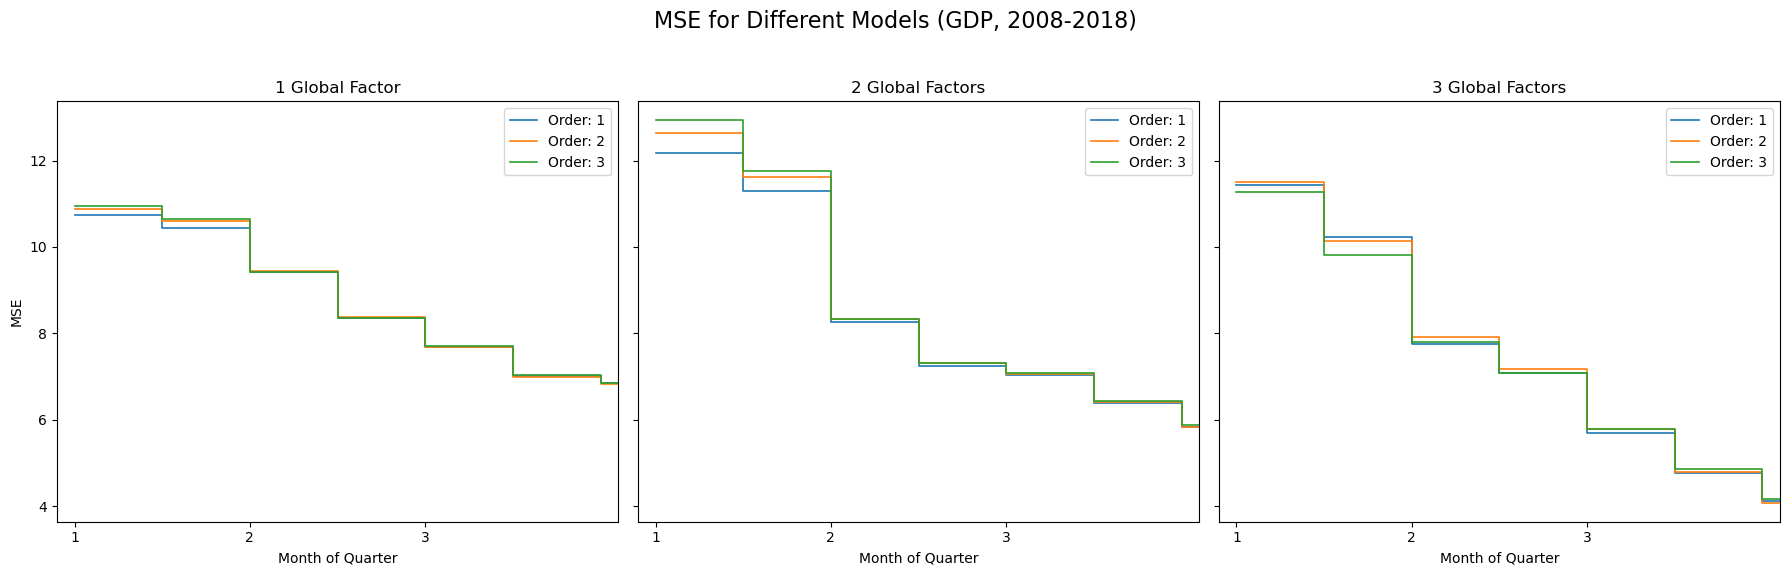

In [2]:
import os
import matplotlib.pyplot as plt
import pandas as pd

vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]
q_var = 'GDP'
text_type = "topics_BCC"
estimation_period = "2009"
num_topics = "200"
source = "all"
selected = "_selected"

# Define a mapping for each vintage to a numeric x-value
x_mapping = {
    "M1-01": 1.0,
    "M1-16": 1.5,
    "M2-01": 2.0,
    "M2-16": 2.5,
    "M3-01": 3.0,
    "M3-16": 3.5,
    "M4-01": 4.0
}

# Construct x values based on the vintages
x_values = [x_mapping[col] for col in vintage_col_names]
# Extend the x array so that the last step extends to the end of the x-axis
x_extended = x_values.copy()
x_extended.append(4.1)  # extend x-axis to 4.1

# Define the directory containing MSE files
mse_dir = f"../MSE/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_global_factors_{q_var}"

# Create a figure with 1 row and 3 columns of subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Loop over each number of global factors (1, 2, and 3)
for i, num_factors in enumerate(range(1, 4)):
    ax = axs[i]
    # Within each subplot, loop over factor orders 1 to 3
    for order in range(1, 4):
        # Construct file name based on the model's parameters
        factors_str = f"Global_{num_factors}_{order}"
        mse_file_name = f"MSE_{q_var}_{factors_str}.csv"
        mse_file_path = os.path.join(mse_dir, mse_file_name)
        
        # Load the MSE values from file
        mse_df = pd.read_csv(mse_file_path)
        # Construct y values based on the vintages
        y_values = [mse_df[col].iloc[0] for col in vintage_col_names]
        
        # Extend the y-values so the step function holds the last value
        y_extended = y_values.copy()
        y_extended.append(y_values[-1]) # Repeat the last value
        
        # Plot the step function for the current model
        ax.step(x_extended, y_extended, where='post', linewidth=1.2, 
                 label=f"Order: {order}")
        
    # Customize the subplot
    ax.set_xlabel("Month of Quarter")
    # Set ticks only at 1, 2, and 3 to mark the beginning of each month
    ax.set_xticks([1, 2, 3])
    ax.set_xlim(0.9, 4.1)
    ax.set_title(f"{num_factors} Global Factor{'s' if num_factors > 1 else ''}")
    if i == 0:  # Only the leftmost subplot gets the y-axis label
        ax.set_ylabel("MSE")
    ax.legend()

plt.suptitle(f"MSE for Different Models ({q_var}, 2008-2018)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Create the "plots" directory if it doesn't exist and save the figure as PNG and EPS
os.makedirs(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_global_factors_{q_var}", exist_ok=True)
base_filename = os.path.join(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_global_factors_{q_var}", f"DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_global_factors_2008-2018_{q_var}")
plt.savefig(f"{base_filename}.png", format="png")
plt.savefig(f"{base_filename}.eps", format="eps")

plt.show()

Plot MSE values for all models evaluated over the 2008–2010 and 2011-2018 periods.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


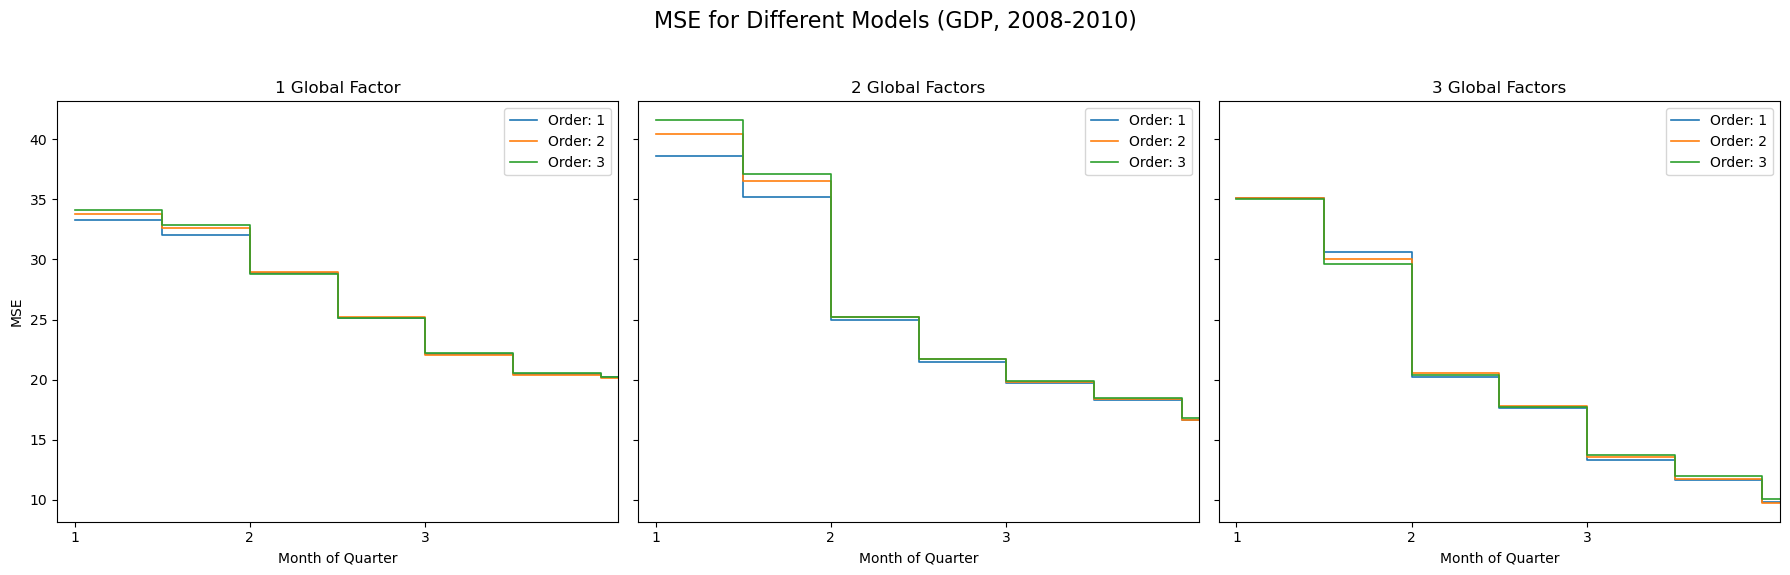

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


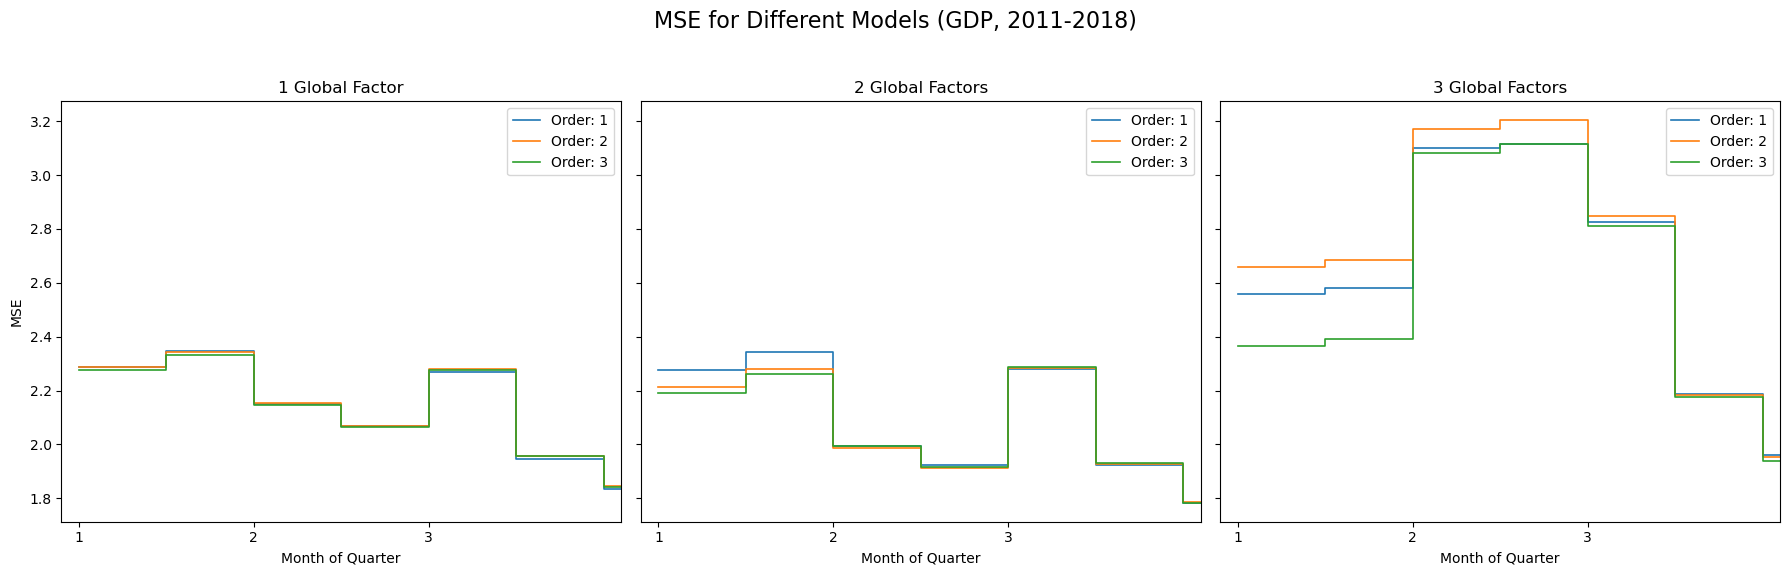

In [3]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def quarter_to_float(q_str):
    """
    Convert a string like 'YYYY-MM'
    into a float: e.g. 2008-03 -> 2008.00, 2008-06 -> 2008.25, etc.
    """
    year = int(q_str[:4])
    month = int(q_str[5:])
    # Map month to fraction of the year
    if month == 3:
        fraction = 0.00
    elif month == 6:
        fraction = 0.25
    elif month == 9:
        fraction = 0.50
    elif month == 12:
        fraction = 0.75
    return year + fraction

# Forecast variable and directories
q_var = 'GDP'
text_type = "topics_BCC"
estimation_period = "2009"
num_topics = "200"
source = "all"
selected = "_selected"
forecasts_dir = f"../forecasts/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_global_factors_{q_var}"
actual_growth_file = f"../{q_var}_growth_actual.csv"

# Vintage columns
vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]

# Load actual growth data and convert 'date' to float
actual_growth = pd.read_csv(actual_growth_file)
actual_growth["date_float"] = actual_growth["date"].apply(quarter_to_float)
actual_growth.sort_values("date_float", inplace=True)

# Define two periods
periods = {
    "2008-2010": lambda df: df["date_float"] < 2011,
    "2011-2018": lambda df: df["date_float"] >= 2011
}

# Define a mapping for each vintage to a numeric x-value
x_mapping = {
    "M1-01": 1.0,
    "M1-16": 1.5,
    "M2-01": 2.0,
    "M2-16": 2.5,
    "M3-01": 3.0,
    "M3-16": 3.5,
    "M4-01": 4.0
}

# Construct x values based on the vintages
x_values = [x_mapping[col] for col in vintage_col_names]
# Extend the x array so that the last step extends to the end of the x-axis
x_extended = x_values.copy()
x_extended.append(4.1)  # extend x-axis to 4.1

# Loop over each period and create a separate figure
for period_label, period_filter in periods.items():
    
    # Create a figure with 1 row and 3 columns of subplots
    fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
    
    # Loop over each number of global factors (1, 2, and 3)
    for i, num_factors in enumerate(range(1, 4)):
        ax = axs[i]
        # Within each subplot, loop over factor orders 1 to 3
        for order in range(1, 4):
            # Construct forecast file name, e.g., "forecasts_GDP_Global_1_1.csv"
            factors_str = f"Global_{num_factors}_{order}"
            forecast_file_name = f"forecasts_{q_var}_{factors_str}.csv"
            forecast_file_path = os.path.join(forecasts_dir, forecast_file_name)
    
            # Load forecast data 
            forecasts = pd.read_csv(forecast_file_path, index_col=0)
            forecasts.index.name = "date"
            forecasts.reset_index(inplace=True)
            
            # Merge forecasts with actual growth 
            merged = pd.merge(forecasts, actual_growth, on="date", how="inner")
            merged["date_float"] = merged["date"].apply(quarter_to_float)
            merged.sort_values("date_float", inplace=True)
            
            # Filter merged data for the current period
            merged_period = merged[ period_filter(merged) ]
            
            # Calculate MSE for each vintage column over the filtered period
            mse_dict = {}
            for col in vintage_col_names:
                mse = ((merged_period[col] - merged_period["growth"]) ** 2).mean()
                mse_dict[col] = mse
                
            # Construct y values based on the vintages
            y_values = [mse_dict[col] for col in vintage_col_names]
            
            # Extend the y-values so the step function holds the last value
            y_extended = y_values.copy()
            y_extended.append(y_values[-1]) # Repeat the last value
            
            # Plot the step function for the current model (order)
            ax.step(x_extended, y_extended, where='post', linewidth=1.2, 
                    label=f"Order: {order}")
            
        # Customize the subplot
        ax.set_xlabel("Month of Quarter")
        # Set ticks only at 1, 2, and 3 to mark the beginning of each month
        ax.set_xticks([1, 2, 3])
        ax.set_xlim(0.9, 4.1)
        ax.set_title(f"{num_factors} Global Factor{'s' if num_factors > 1 else ''}")
        if i == 0:  # Only the leftmost subplot gets the y-axis label
            ax.set_ylabel("MSE")
        ax.legend()
   
    plt.suptitle(f"MSE for Different Models ({q_var}, {period_label})", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # Create the "plots" directory if it doesn't exist and save the figure as PNG and EPS
    os.makedirs(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_global_factors_{q_var}", exist_ok=True)
    base_filename = os.path.join(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_global_factors_{q_var}", f"DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_global_factors_{period_label}_{q_var}")
    plt.savefig(f"{base_filename}.png", format="png")
    plt.savefig(f"{base_filename}.eps", format="eps")

    plt.show()

Plot forecasts vs actual growth values for all models and different time periods (2008-2010, 2008-2018, and 2011-2018).

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


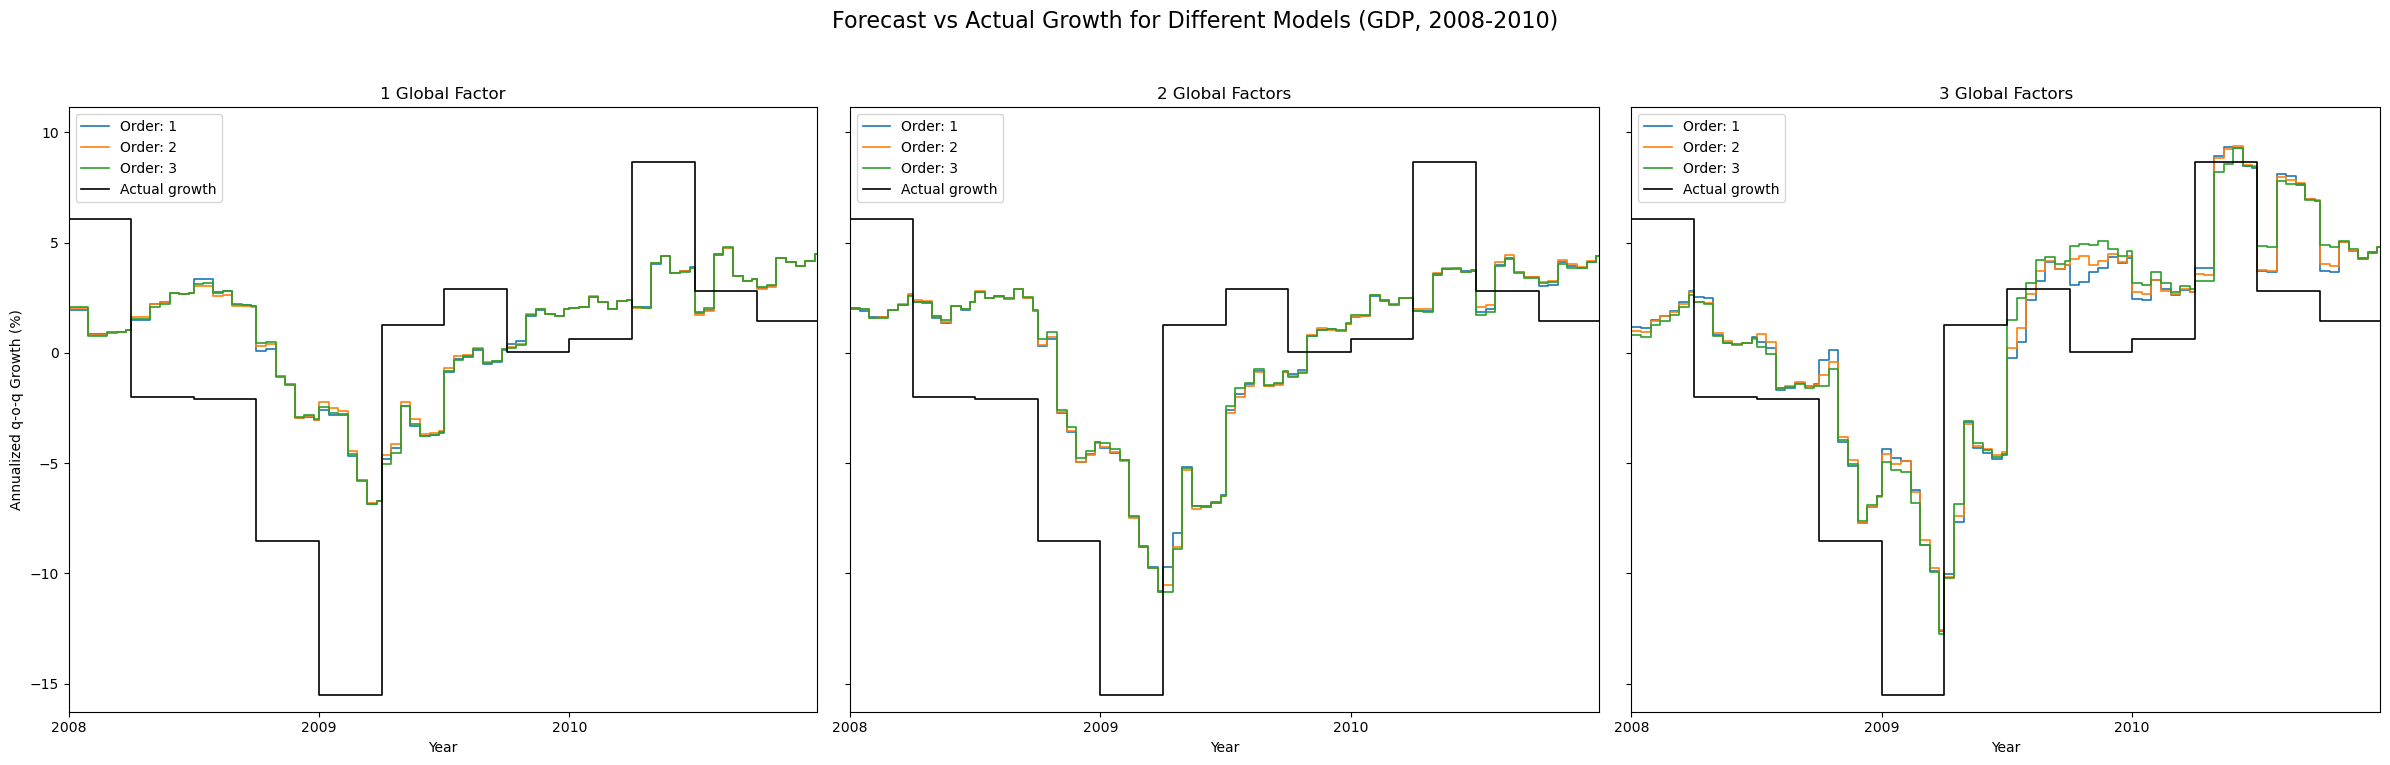

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


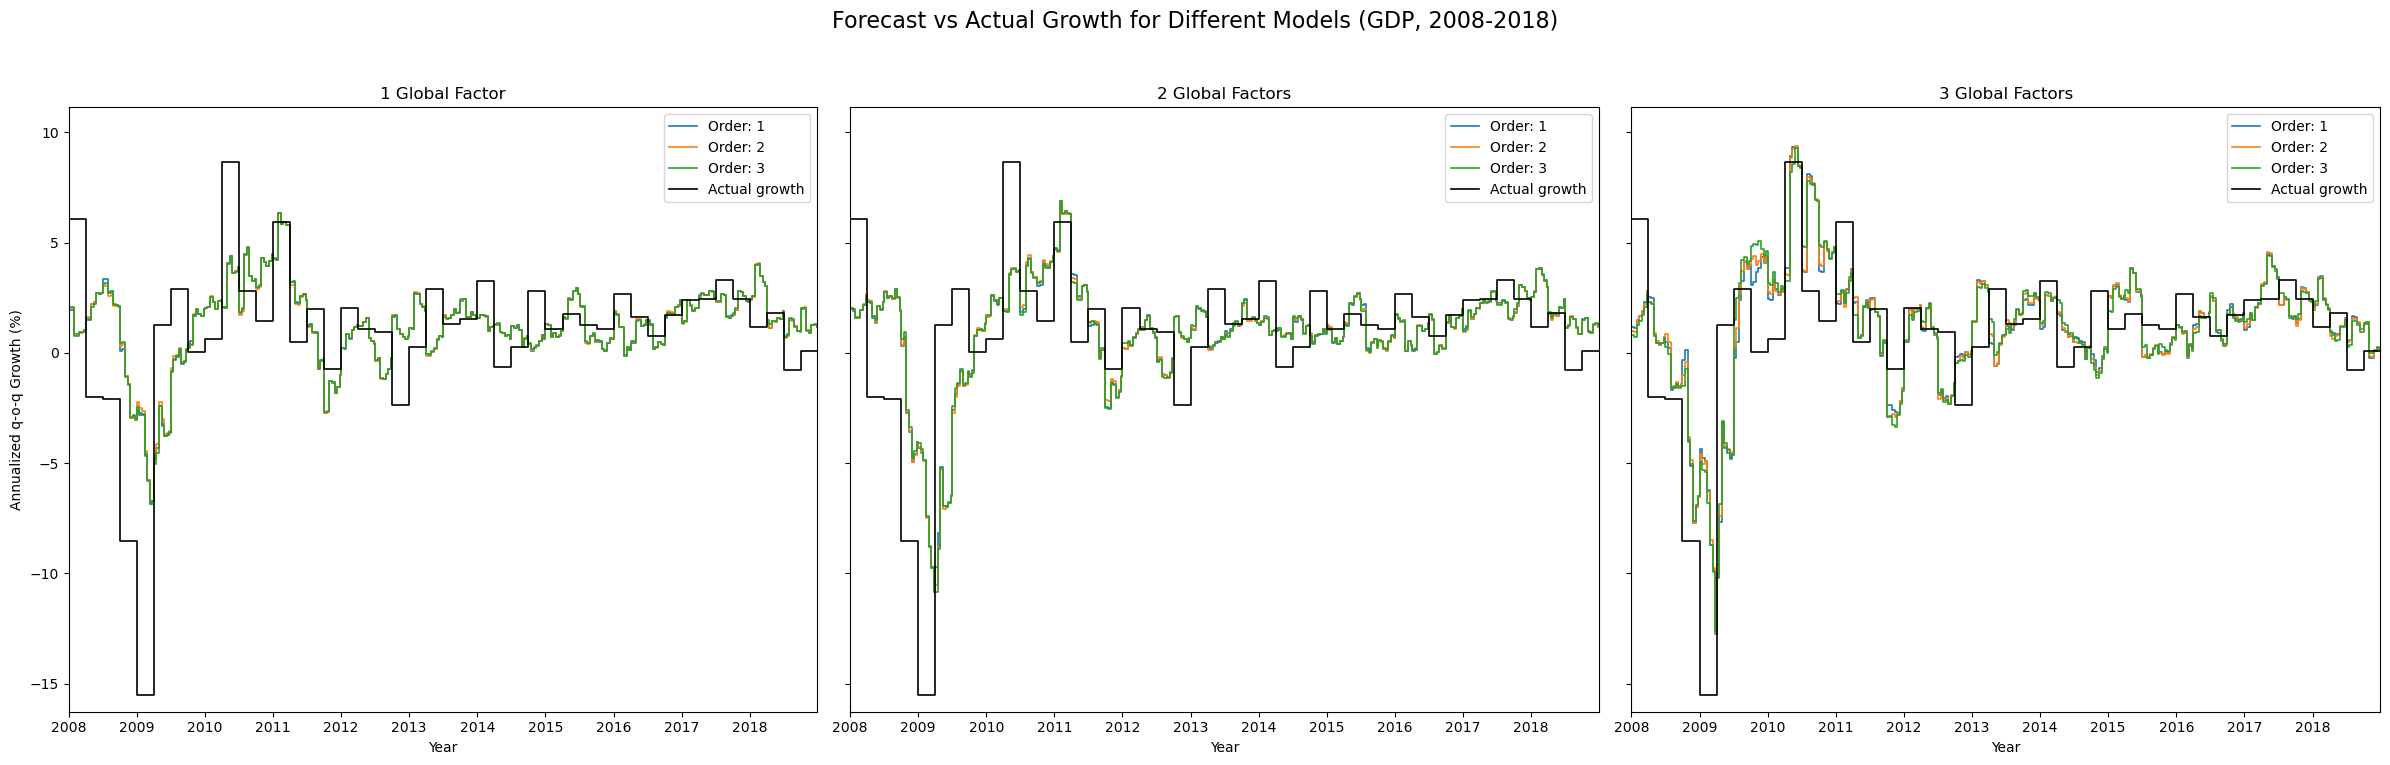

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


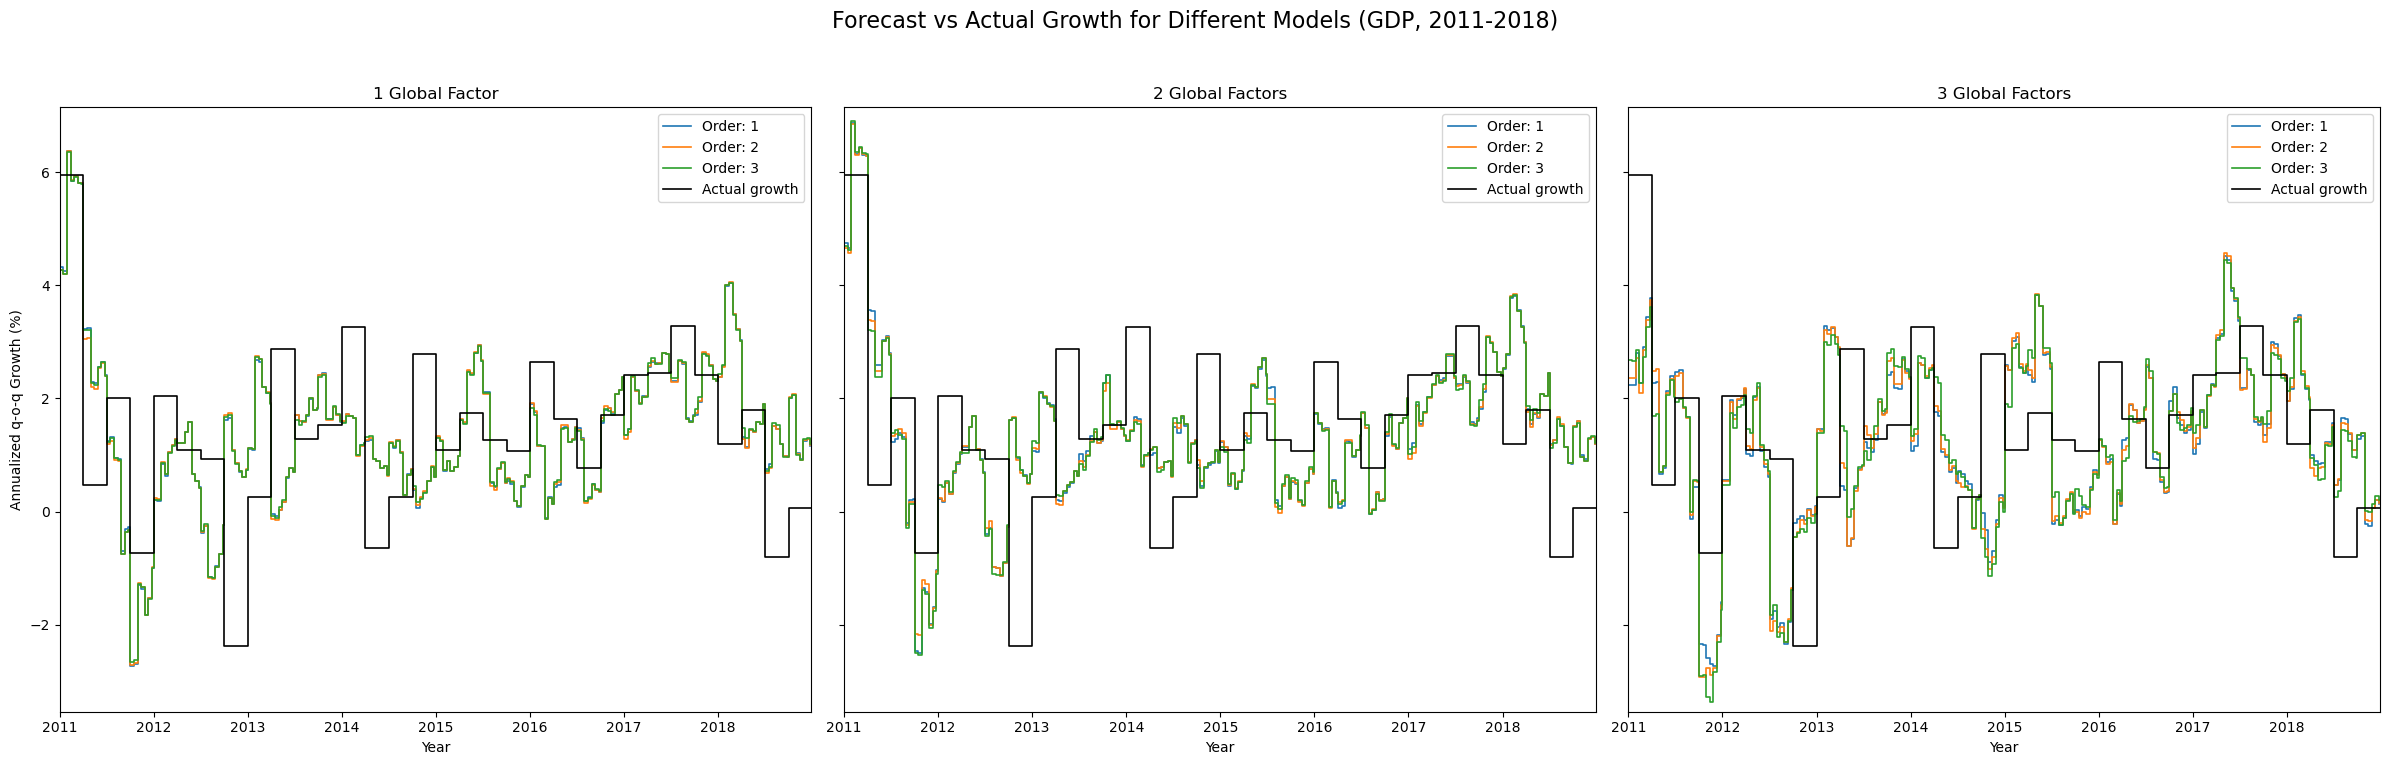

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Convert quarter strings like "2008-03" into a float (e.g. 2008.00 for Q1, 2008.25 for Q2, etc.)
def quarter_to_float(q_str):
    """
    Convert a string like 'YYYY-MM'
    into a float: e.g. 2008-03 -> 2008.00, 2008-06 -> 2008.25, etc.
    """
    year = int(q_str[:4])
    month = int(q_str[5:])
    # Map month to fraction of the year
    if month == 3:
        fraction = 0.00
    elif month == 6:
        fraction = 0.25
    elif month == 9:
        fraction = 0.50
    elif month == 12:
        fraction = 0.75
    return year + fraction

# Forecast variable and directories
q_var = 'GDP'
text_type = "topics_BCC"
estimation_period = "2009"
num_topics = "200"
source = "all"
selected = "_selected"
forecasts_dir = f"../forecasts/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_global_factors_{q_var}"
actual_growth_file = f"../{q_var}_growth_actual.csv"

# Vintage columns
vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]

# Assign 7 small offsets within each quarter, so each quarter has 7 forecast points
offsets = np.linspace(0, 0.23, 7)

# Load actual growth data and convert 'date' to float
actual_growth = pd.read_csv(actual_growth_file)
actual_growth["date_float"] = actual_growth["date"].apply(quarter_to_float)
actual_growth.sort_values("date_float", inplace=True)

# Build x,y arrays for the actual growth
x_act = actual_growth["date_float"].tolist()
y_act = actual_growth["growth"].tolist()

# Define period configurations: x-axis limits and tick positions for each period
period_configs = {
    "2008-2010": {"xlim": (2008, 2010.99), "xticks": list(range(2008, 2011))},
    "2008-2018": {"xlim": (2008, 2018.99), "xticks": list(range(2008, 2019))},
    "2011-2018": {"xlim": (2011, 2018.99), "xticks": list(range(2011, 2019))}
}

# Loop over each period configuration to create and save separate plots
for period_label, config in period_configs.items():
    
    # Extend the actual growth arrays so that the step function continues until the end of the x-axis
    if period_label in ["2008-2018", "2011-2018"]:
        x_act_extended = x_act.copy()
        x_act_extended.append(config["xlim"][1])
        y_act_extended = y_act.copy()
        y_act_extended.append(y_act[-1])
    else:
        x_act_extended = x_act
        y_act_extended = y_act

    # Create a figure with 1 row and 3 columns for the three global factor counts
    fig, axs = plt.subplots(1, 3, figsize=(24, 8), sharey=True)

    # Loop over each global factor count (1, 2, and 3)
    for i, num_factors in enumerate([1, 2, 3]):
        ax = axs[i]

        # For each global factor count, plot forecasts for orders 1, 2, and 3
        for order in range(1, 4):

            # Construct forecast file name, e.g., "forecasts_GDP_Global_1_1.csv"
            factors_str = f"Global_{num_factors}_{order}"
            forecast_file_name = f"forecasts_{q_var}_{factors_str}.csv"
            forecast_file_path = os.path.join(forecasts_dir, forecast_file_name)

            # Load forecast data 
            forecasts = pd.read_csv(forecast_file_path, index_col=0)
            forecasts.index.name = "date"
            forecasts.reset_index(inplace=True)

            # Merge forecasts with actual growth dates
            merged = pd.merge(forecasts, actual_growth[['date']], on="date", how="inner")
            merged["date_float"] = merged["date"].apply(quarter_to_float)
            merged.sort_values("date_float", inplace=True)

            # Build forecast x and y arrays 
            x_fore = []
            y_fore = []
            for idx, row in merged.iterrows():
                base_x = row["date_float"]
                # For each of the 7 vintage columns, define an x-position and take that forecast value
                for j, col in enumerate(vintage_col_names):
                    x_fore.append(base_x + offsets[j])
                    y_fore.append(row[col])

            # Plot the forecast step curve for the current order
            ax.step(x_fore, y_fore, where='post', linewidth=1.2, label=f"Order: {order}")

        # Plot actual growth as a step plot in each subplot
        ax.step(x_act_extended, y_act_extended, where='post', color='black', linewidth=1.2, label="Actual growth")

        # Customize the subplot
        ax.set_xlabel("Year")
        ax.set_xlim(config["xlim"][0], config["xlim"][1])
        ax.set_xticks(config["xticks"])
        
        # Set y-axis limits based on the data within the period range
        x_min, x_max = config["xlim"]
        def filter_points(x_arr, y_arr, x_min, x_max):
            return [y for x, y in zip(x_arr, y_arr) if x_min <= x <= x_max]

        # Filter y-values
        y_filtered = filter_points(x_fore, y_fore, x_min, x_max)
        y_act_filtered = filter_points(x_act_extended, y_act_extended, x_min, x_max)
        
        # Combine all filtered y-values
        combined_y = y_filtered + y_act_filtered
        ax.set_ylim(1.05 * min(combined_y), 1.2 * max(combined_y))
        
        ax.set_title(f"{num_factors} Global Factor{'s' if num_factors > 1 else ''}")
        if i == 0:
            ax.set_ylabel("Annualized q-o-q Growth (%)")
        ax.legend()
        
    plt.suptitle(f"Forecast vs Actual Growth for Different Models ({q_var}, {period_label})", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # Create the "plots" directory if it doesn't exist and save the figure as PNG and EPS
    os.makedirs(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_global_factors_{q_var}", exist_ok=True)
    base_filename = os.path.join(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_global_factors_{q_var}", f"DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_global_factors_forecast_vs_actual_{period_label}_{q_var}")
    plt.savefig(f"{base_filename}.png", format="png")
    plt.savefig(f"{base_filename}.eps", format="eps")

    plt.show()